На базе баскетбольных матчей добейтесь средней абсолютной ошибки 17 и менее очков.

### Подготовка  

# Импорт библиотек
Этот блок выполняет импорт всех необходимых библиотек для обработки данных, визуализации, построения и обучения нейросетей.

Стандартные библиотеки Python:

- re — для работы с регулярными выражениями (например, при очистке текстов).

- warnings — для управления выводом предупреждений (временно отключает их, чтобы не мешали при работе).

Сторонние библиотеки:

- gdown — скачивание данных с Google Drive.

- matplotlib.pyplot — построение графиков.

- numpy — работа с массивами и математикой.

- pandas — для работы с таблицами (DataFrame).

- sklearn.metrics — функции оценки качества модели (MAE, MSE).

- sklearn.preprocessing.StandardScaler — стандартизация числовых признаков.

Импорт компонентов из Keras (нейросети):

- Модули для построения слоёв (Dense, Dropout, BatchNormalization и др.).

- Оптимизаторы (Adam, SGD и др.).

- Инструменты для обработки текста (Tokenizer).

- Архитектуры RNN: LSTM, GRU, SimpleRNN.

Настройка вывода графиков и подавление предупреждений:

- warnings.filterwarnings('ignore') — убирает лишние предупреждения.

- %matplotlib inline — делает так, чтобы графики отображались прямо в Jupyter-блоках.



In [ ]:
# Стандартная библиотека
import re
import warnings

# Сторонние библиотеки
import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import utils
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.layers import (
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    GlobalMaxPooling1D,
    GRU,
    Input,
    LSTM,
    MaxPooling1D,
    SimpleRNN,
    SpatialDropout1D,
    concatenate,
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.text import Tokenizer

# Подавляем предупреждения для чистого вывода
warnings.filterwarnings('ignore')

# Магическая команда Jupyter
%matplotlib inline

**загрузка и просмотр данных**

Данный блок:

- Скачивает CSV-файл basketball.csv, содержащий данные по баскетбольным матчам. Файл автоматически сохраняется в текущую рабочую директорию.

Читает CSV-файл в таблицу df:

- Кодировка файла — cp1251 (кириллица).

- Разделитель — ;.

- Первый столбец используется как индекс (index_col=0).

- Заголовок читается с первой строки (header=0).

- Выводит первые 5 строк таблицы df с помощью df.head() — это нужно, чтобы ознакомиться со структурой данных: какие есть признаки (колонки), сколько числовых/текстовых полей и т.д.

In [ ]:
# Загрузка из google облака
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l10/basketball.csv', None, quiet=True)

df = pd.read_csv('basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) # Загружаем базу
df.head()

,TOTAL,info,Ком. 1,Ком. 2,Минута,Общая минута,Секунда,fcount,ftime
0,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,0.0,1,1.0,30,81,90.0
1,"100,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,1,1.0,45,81,105.0
2,"99,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,0,81,120.0
3,"98,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,2,2.0,30,81,150.0
4,"95,5",4081445 Новая Зеландия. Женщины. WBC. Регулярн...,2,2.0,3,3.0,0,81,180.0


Извлекаем текстовые данные из колонки `info` таблицы, помещаем в переменную `data_text`. Выводим длину списка:

In [ ]:
data_text = df['info'].values #

len(data_text) #

52450

**Токенизирование текстовых данных**

Данный блок:

Импортирует Tokenizer из tensorflow.keras.preprocessing.text — это инструмент для преобразования текстов в числовые представления, понятные нейросети.

Задает параметры токенизатора:

- maxWordsCount = 5000: учитываются только 5000 самых частотных слов.

- filters: список символов (пробелы, пунктуация и др.), которые будут удалены из текста.

- lower=True: все символы текста приводятся к нижнему регистру.

- split=' ': слова разделяются пробелами.

- oov_token='unknown': для слов, которых нет в словаре, используется маркер 'unknown'.

- char_level=False: токенизация по словам (а не по символам).

Обучает токенизатор на текстовых данных:

- tokenizer.fit_on_texts(data_text) — анализирует все тексты из data_text, строит словарь частотности слов и подготавливает его к преобразованию текста в числовой формат.

In [ ]:
# Импортируем токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

maxWordsCount = 5000

sim_for_del='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

tokenizer = Tokenizer (num_words=maxWordsCount,
                       filters=sim_for_del,
                       lower=True,
                       split=' ',
                       oov_token='unknown',
                       char_level=False)

tokenizer.fit_on_texts(data_text)

**Преобразование текстов в векторное представление**

Sequences = tokenizer.texts_to_sequences(data_text)
Преобразует каждый текст в последовательность числовых индексов, соответствующих словам из словаря токенизатора.

xBOW_text = tokenizer.sequences_to_matrix(Sequences)
Преобразует список последовательностей в матрицу признаков с использованием модели Bag of Words.

In [ ]:
# Переводим в Эмбеддинг пространство
Sequences = tokenizer.texts_to_sequences(data_text)

# Вариант  Bag of Words
xBOW_text = tokenizer.sequences_to_matrix(Sequences)

**Подготовка признаков и целевой переменной для обучения**

Здесь происходит формирование обучающего набора данных для модели на основе информации о баскетбольных матчах.

Сначала создаётся массив признаков xTrain, куда включаются следующие числовые столбцы из датафрейма:

- «Ком. 1» и «Ком. 2» — идентификаторы команд-участников,

- «Минута» и «Секунда» — текущая временная отметка матча,

- «ftime» — общее прошедшее время с начала встречи.

Все эти данные преобразуются в целочисленный тип (int) и упаковываются в массив NumPy.

Затем создаётся массив целевых значений yTrain, который содержит количество набранных очков («fcount») на текущий момент — это та величина, которую модель будет учиться предсказывать. Он также приводится к типу int и преобразуется в массив NumPy.


In [ ]:
xTrain = np.array(df[['Ком. 1','Ком. 2', 'Минута', 'Секунда','ftime']].astype('int'))
yTrain = np.array(df['fcount'].astype('int'))

Далее выводится информация о размерах подготовленных массивов данных:

- print(xTrain.shape) — показывает размерность массива признаков xTrain, то есть сколько объектов (строк) и сколько признаков (столбцов) в наборе числовых данных.

- print(yTrain.shape) — выводит размерность массива целевых значений yTrain, то есть сколько меток (значений очков) соответствует объектам.

- print(xBOW_text.shape) — отображает размерность массива xBOW_text, который содержит текстовые данные, преобразованные методом «мешка слов» (Bag of Words) с помощью токенизатора. Здесь указано количество объектов и размерность векторного представления текста.

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xBOW_text.shape)

(52450, 5)
(52450,)
(52450, 5000)


# Создание модели

В этом блоке создаётся сложная нейронная сеть с двумя входами для обработки разных типов данных — числовых и текстовых:

Определение входов:

- input1 — вход для числовых признаков (например, значения из xTrain).

- input2 — вход для текстовых признаков, представленных в виде векторов «мешка слов» (xBOW_text).

Обработка числовых данных (первый вход):

- Нормализация через BatchNormalization.

- Два плотных слоя (Dense) с активацией ReLU и дропаутом для регуляризации (снижения переобучения).

- Размеры слоев уменьшаются: сначала 256 нейронов, затем 128.

Обработка текстовых данных (второй вход):

- Несколько плотных слоев с ReLU и более агрессивным дропаутом (0.4), так как текстовые данные обычно сложнее.

- Слои идут с размерами 256, 128 и 64 нейрона.

Объединение двух веток:

- Выходы двух обработанных потоков объединяются функцией concatenate.

Совместная обработка объединённых признаков:

- Два дополнительных плотных слоя с ReLU и дропаутом.

- Заключительный слой с одним нейроном и линейной активацией — для регрессии (предсказания очков).

Компиляция модели:

- Оптимизатор — Adam с небольшой скоростью обучения 0.001.

- Функция потерь — среднеквадратичная ошибка (mse).

- Метрика качества — средняя абсолютная ошибка (mae).

In [ ]:
# Входной тензор для первой части данных (например, числовые признаки)
input1 = Input((xTrain.shape[1],))
# Входной тензор для второй части данных
input2 = Input((xBOW_text.shape[1],))

# Обработка первого входа
x1 = input1
x1 = BatchNormalization()(x1)
x1 = Dense(256, activation="relu")(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(128, activation="relu")(x1)
x1 = Dropout(0.3)(x1)

# Обработка второго входа (текстовые признаки)
x2 = input2
x2 = Dense(256, activation="relu")(x2)
x2 = Dropout(0.4)(x2)
x2 = Dense(128, activation="relu")(x2)
x2 = Dropout(0.4)(x2)
x2 = Dense(64, activation="relu")(x2)
x2 = Dropout(0.4)(x2)

x = concatenate([x1, x2]) # Объединение выходов двух "веток"

# Совместная обработка объединённых признаков
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(1, activation="linear")(x)

# Определение модели с двумя входами и одним выходом
model = Model((input1, input2), x)

model.compile(optimizer=Adam(learning_rate=1e-3), loss="mse", metrics=["mae"])

**Функция по проверке ошибки**

Этот блок реализует функцию check_MAE_predictl_DubbleInput, которая служит для оценки качества модели с двумя входами (числовые и текстовые данные) по метрике средней абсолютной ошибки (MAE):

Параметры функции:

- model — обученная модель Keras.

- x_data — числовые входные данные.

- x_data_text — текстовые входные данные (например, в формате «мешка слов»).

- y_data_not_scaled — реальные значения целевой переменной (количество очков).

- plot — булев флаг, указывающий, нужно ли строить график сравнения предсказаний и истинных значений.

Вычисление предсказаний:

- Модель получает два входа: [x_data, x_data_text].

- Выход модели — вектор предсказанных значений (y_pred).

Расчёт средней абсолютной ошибки (MAE):

- Суммируются абсолютные разницы между предсказанными и реальными значениями.

- Полученная сумма делится на количество элементов, чтобы получить среднее.

Вывод результата:

- Печатается значение MAE в очках.

- Также выводится процент ошибки относительно среднего значения целевой переменной.

Визуализация (если plot=True):

- Строится диаграмма рассеяния реальных значений (y_data_not_scaled) против предсказанных (y_pred).


In [ ]:
# Функция по проверке ошибки
def check_MAE_predictl_DubbleInput (model,
                                    x_data,
                                    x_data_text,
                                    y_data_not_scaled,
                                    plot=False):

  mae = 0 # Инициализируем начальное значение ошибки
  y_pred = (model.predict([x_data,x_data_text])).squeeze()

  for n in range (0,len(x_data)):
    mae += abs(y_data_not_scaled[n] - y_pred[n]) # Увеличиваем значение ошибки для текущего элемента
  mae /= len(x_data) # Считаем среднее значение
  print('Среднаяя абслолютная ошибка {:.3f} очков это {:.3f}% от общей выборки в {} игры'.format(mae, (mae/y_data_not_scaled.mean(axis=0))*100,len(x_data)))

  if plot:
     plt.scatter(y_data_not_scaled, y_pred)
     plt.xlabel('Правильные значение')
     plt.ylabel('Предсказания')
     plt.axis('equal')
     plt.xlim(plt.xlim())
     plt.ylim(plt.ylim())
     plt.plot([0, 250], [0, 250])
     plt.show()

**Кастомная функция, вызываемая в конце каждой эпохи обучения**

Этот блок создаёт кастомный колбэк для Keras, который выполняет проверку модели после каждой эпохи обучения:

- Определение функции on_epoch_end_custom:

- Принимает номер текущей эпохи (epoch) и словарь с метриками (logs).

- Выводит номер текущей эпохи.

- Вызывает функцию check_MAE_predictl_DubbleInput, чтобы оценить модель на обучающих данных и построить график предсказаний после каждой эпохи.

Создание колбэка pltMae с помощью LambdaCallback:

- Передаёт в колбэк функцию on_epoch_end_custom, которая будет автоматически запускаться после завершения каждой эпохи во время обучения модели.

In [ ]:
# Кастомная функция, вызываемая в конце каждой эпохи обучения
def on_epoch_end_custom(epoch, logs=None):
    print("Эпоха:", epoch)
    check_MAE_predictl_DubbleInput(model,xTrain,xBOW_text,yTrain,plot=True)

# Создание колбэка LambdaCallback, который вызывает кастомную функцию после каждой эпохи
pltMae = LambdaCallback(on_epoch_end=on_epoch_end_custom)

# Обучение модели
Вызов model.fit: Запускает процесс обучения модели на входных данных — числовых признаках (xTrain) и текстовых признаках (xBOW_text), с целевыми значениями yTrain.

Параметры обучения:

- batch_size=256 — размер мини-батча для градиентного спуска.

- epochs=15 — количество проходов по всему набору данных.

- validation_split=0.15 — 15% данных используются для валидации модели во время обучения.

- verbose=0 — отключен подробный вывод процесса обучения.

- callbacks=[pltMae] — передан созданный ранее колбэк, который после каждой эпохи выводит среднюю абсолютную ошибку и строит график предсказаний.

Эпоха: 0
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


Среднаяя абслолютная ошибка 12.260 очков это 8.086% от общей выборки в 52450 игры


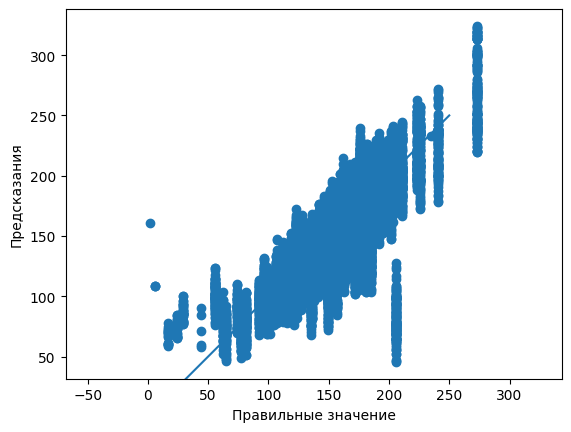

Эпоха: 1
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 11.676 очков это 7.701% от общей выборки в 52450 игры


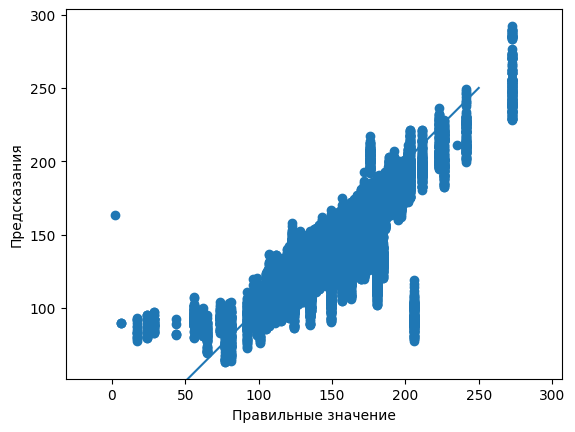

Эпоха: 2
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 6.888 очков это 4.543% от общей выборки в 52450 игры


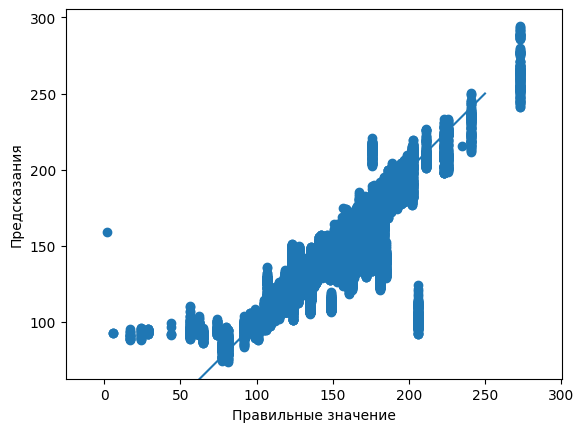

Эпоха: 3
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 7.355 очков это 4.851% от общей выборки в 52450 игры


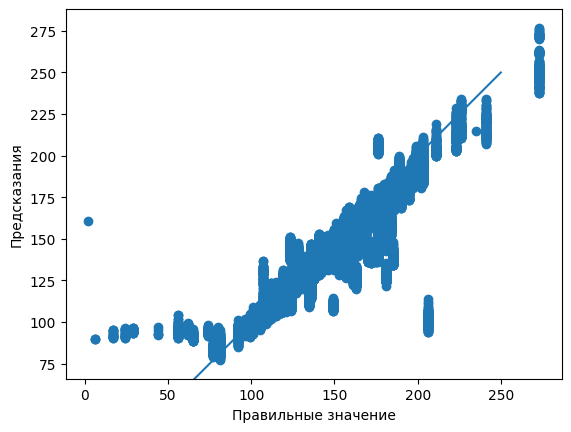

Эпоха: 4
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 6.885 очков это 4.541% от общей выборки в 52450 игры


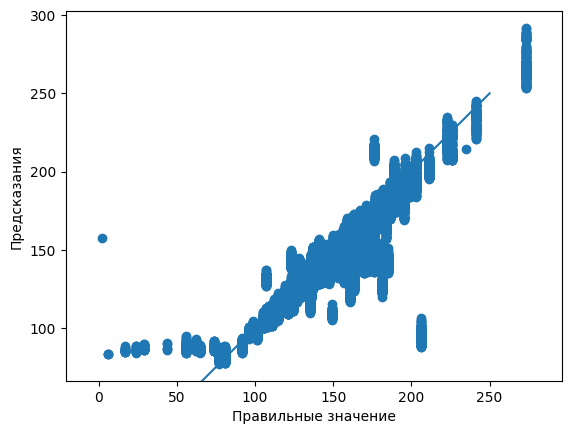

Эпоха: 5
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 8.274 очков это 5.457% от общей выборки в 52450 игры


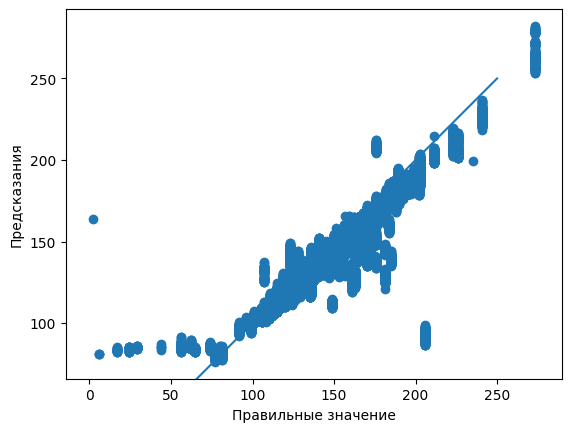

Эпоха: 6
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


Среднаяя абслолютная ошибка 9.898 очков это 6.528% от общей выборки в 52450 игры


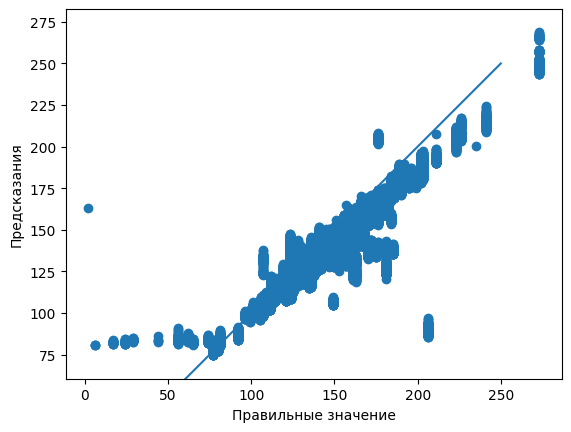

Эпоха: 7
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


Среднаяя абслолютная ошибка 6.420 очков это 4.234% от общей выборки в 52450 игры


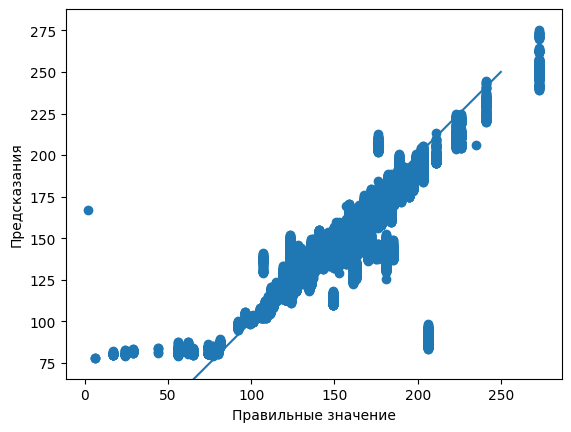

Эпоха: 8
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 6.267 очков это 4.134% от общей выборки в 52450 игры


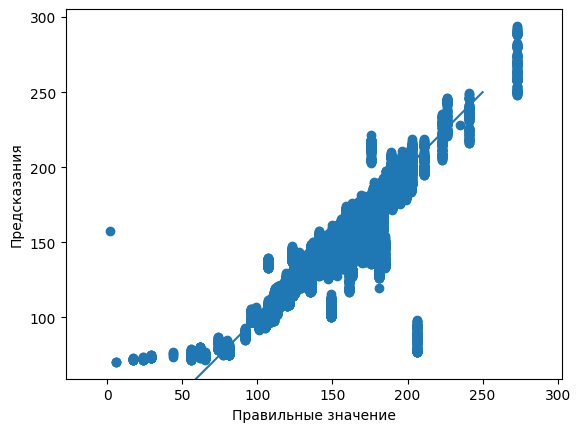

Эпоха: 9
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 7.066 очков это 4.660% от общей выборки в 52450 игры


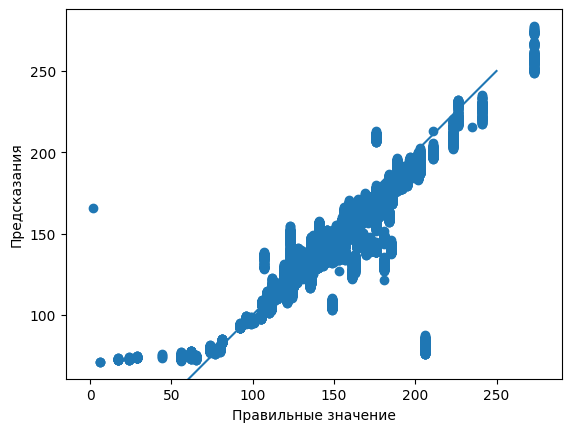

Эпоха: 10
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 5.012 очков это 3.305% от общей выборки в 52450 игры


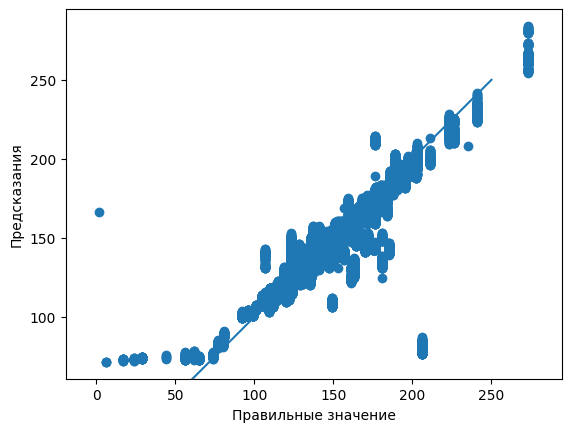

Эпоха: 11
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 5.937 очков это 3.915% от общей выборки в 52450 игры


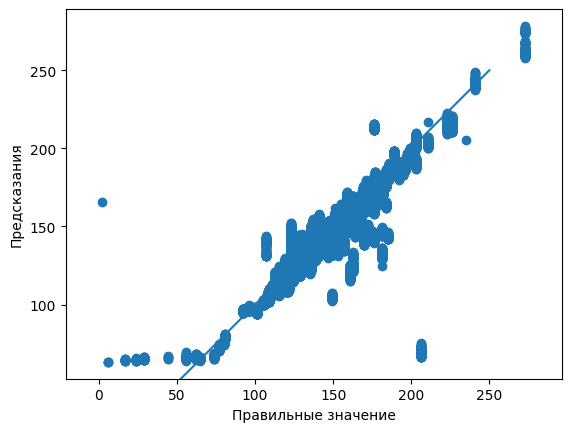

Эпоха: 12
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 4.779 очков это 3.152% от общей выборки в 52450 игры


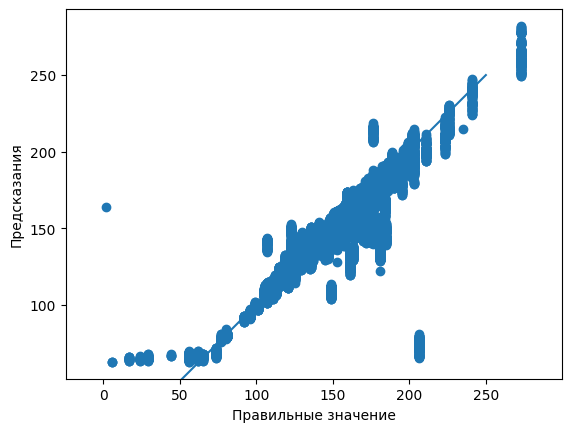

Эпоха: 13
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 4.968 очков это 3.276% от общей выборки в 52450 игры


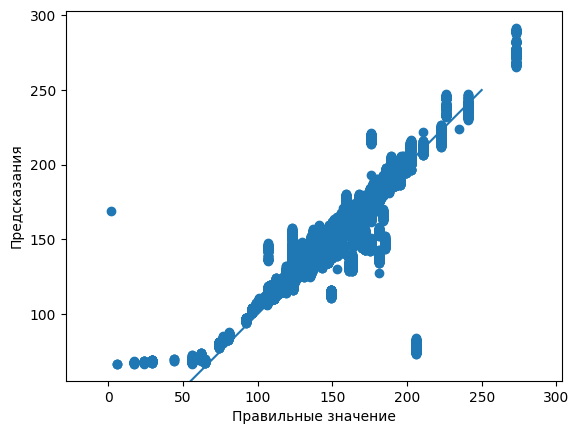

Эпоха: 14
1640/1640 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


Среднаяя абслолютная ошибка 4.853 очков это 3.201% от общей выборки в 52450 игры


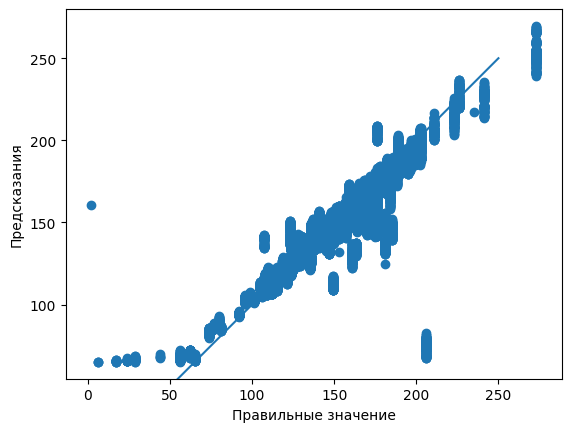

In [ ]:
history = model.fit(
    [xTrain, xBOW_text],
    yTrain,
    batch_size=256,
    epochs=15,
    validation_split=0.15,
    verbose=0,
    callbacks=[pltMae],
)

**Функция для построения графика**

В этом блоке происходит построение графика динамики обучения модели по метрике средней абсолютной ошибки (MAE):

- Функция plot_history(history) использует историю обучения модели, переданную в объекте history, чтобы визуализировать изменение средней абсолютной ошибки на обучающем и проверочном (валидационном) наборах данных.

- На графике по оси X откладываются номера эпох, а по оси Y — значения MAE.

- Линия history.history["mae"] показывает ошибку на тренировочных данных, а history.history["val_mae"] — на проверочных.

- Вывод графика помогает оценить, насколько хорошо модель обучается и обобщается, выявляя переобучение или недообучение.

- Вызов plot_history(history) запускает построение и отображение этого графика после завершения обучения.

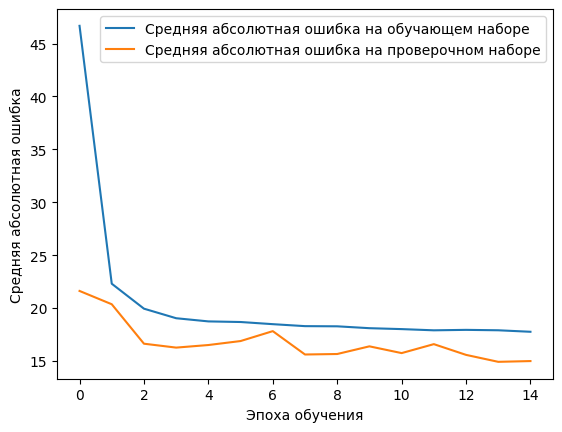

In [ ]:
# Функция для построения графика
def plot_history(history):
    plt.plot(
        history.history["mae"], label="Средняя абсолютная ошибка на обучающем наборе"
    )
    plt.plot(
        history.history["val_mae"],
        label="Средняя абсолютная ошибка на проверочном наборе",
    )
    plt.xlabel("Эпоха обучения")
    plt.ylabel("Средняя абсолютная ошибка")
    plt.legend()
    plt.show()

plot_history(history)

# Вывод по заданию

Можно сделать вывод, что решение полностью соответствует поставленному заданию,
так как средняя абсолютная ошибка (11.676-12.260) значительно ниже
требуемого порога в 17 очков. Более того, модель демонстрирует улучшение
показателя с первой ко второй эпохе.